# Entrenamiento con Mobilenet V2

#Aplicación movil para detectar al menos cinco señales de transito

Entrenamiento utilizando arquitetura Mobilenet v2 para la detección de 6 señales de transito:



1.   Cruce Peatonal
2.   Parada de bus
3.   Pare
4.   Semaforo peatonal rojo
5.   Semaforo peatonal verde
6.   Proximidad de cruce de peatones

#1. Se instalan las dependencias.

In [11]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from google.colab import drive
drive.mount('/content/drive/')      

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from string import ascii_uppercase
from tensorflow.keras.preprocessing import image
import cv2
import pandas as pd
from tensorflow.keras.applications import imagenet_utils
import seaborn as sns

#2. Se descarga el dataset desde robowflow.

 Se carga la base de datos 'señales de transito' que contiene imágenes de señales transito peatonales divididas en directorios de entrenamiento, validación y prueba. Todos los datos son ajustados a un tamaño de 240*240

In [14]:
from roboflow import Roboflow
rf = Roboflow(api_key="FjRJBWAOVtNSsRDSP6ju")
project = rf.workspace("tesis-lhuim").project("trafficsignalsmobilenetv2")
dataset = project.version(3).download("folder")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to TrafficSignalsMobileNetV2-3 in folder:: 100%|██████████| 6039/6039 [00:02<00:00, 2417.97it/s]


In [15]:
# Se añade el dataset a un folder
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('/content/TrafficSignalsMobileNetV2-3/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/content/TrafficSignalsMobileNetV2-3/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=6),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=508, num_shards=1>,
        'train': <SplitInfo num_examples=5000, num_shards=1>,
        'valid': <SplitInfo num_examples=508, num_shards=1>,
    },
    citation="""""",
)


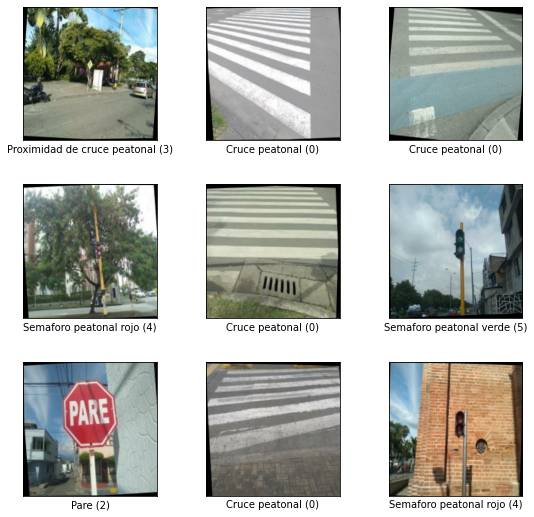

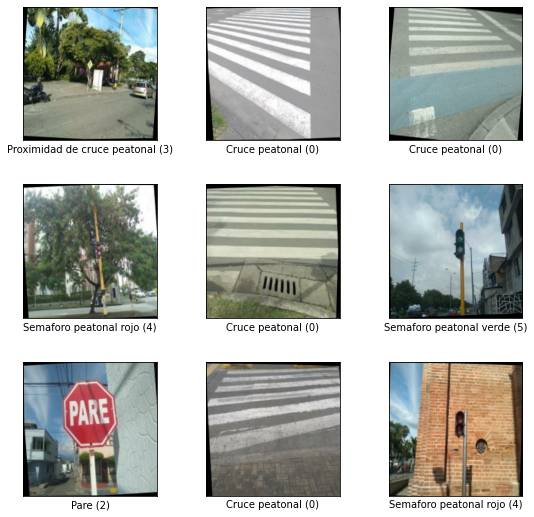

In [16]:
tfds.show_examples(raw_train, builder.info)

#3. Pre procesamiento de las imagenes

Se ajustan las imagenes a 224*224 y si dividen los datos en direcorios de entrenamiento, validación y prueba.

In [17]:
IMG_SIZE = 224 # Se cambia el tamaño de todas las imagenes 

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [18]:
#Se divide el dataset
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [19]:
#Se agrega el batch
train_batches = train.batch(32)
validation_batches = validation.batch(32)
test_batches = test.batch(32)

In [20]:
for image_batch, label_batch in test_batches:
   pass

label_batch.shape

TensorShape([28])

In [21]:
for images, labels in train_batches:  # only take first element of dataset
    numpy_images_train = images.numpy()
    numpy_labels_train = labels.numpy()

In [22]:
numpy_images_train.shape

(8, 224, 224, 3)

In [23]:
for images, labels in test_batches:  # only take first element of dataset
    numpy_images_test = images.numpy()
    numpy_labels_test = labels.numpy()

In [24]:
numpy_labels_test.shape

(28,)

In [25]:
numpy_images_test.shape

(28, 224, 224, 3)

In [26]:
for images, labels in validation_batches:  # only take first element of dataset
    numpy_images_val = images.numpy()
    numpy_labels_val = labels.numpy()

In [27]:
numpy_labels_val.shape

(28,)

In [28]:
print(numpy_labels_test)

[5 5 1 4 5 3 4 0 0 5 4 4 5 5 5 1 1 4 4 1 0 2 1 1 5 5 2 3]


#4. Se crea el modelo secuencial de Mobilenet v2

Una ves listo la base de datos se crea el modelo Mobilenet v2 y se entrena la red con 100 epocas, img 240 y train_batches = 32.

In [29]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(6,activation = "softmax")

In [31]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


In [34]:
history = model.fit(train_batches,
                    epochs=100,
                    shuffle=True,
                    validation_data=(validation_batches))

Epoch 1/100


UnimplementedError: ignored

#5. Desempeño de la red

Se valida el desempeño de la Mobilnet v2 con metricas como el mAP, recall, precision y funcion de perdida. De igual forma se muestran los resultados en graficas y matrices de confusión.

In [ ]:
train_acc_list, test_acc_list = [], []

train_loss, train_acc = model.evaluate(train_batches, steps=len(train_batches))
val_loss, val_acc = model.evaluate(validation_batches, steps=len(validation_batches))
test_loss, test_acc = model.evaluate(test_batches, steps=len(test_batches))

train_acc_list.append(train_acc)
test_acc_list.append(val_acc)
train_acc_list.append(test_acc)

1/1 [==============================] - 5s 5s/step - loss: 0.2354 - accuracy: 0.9626


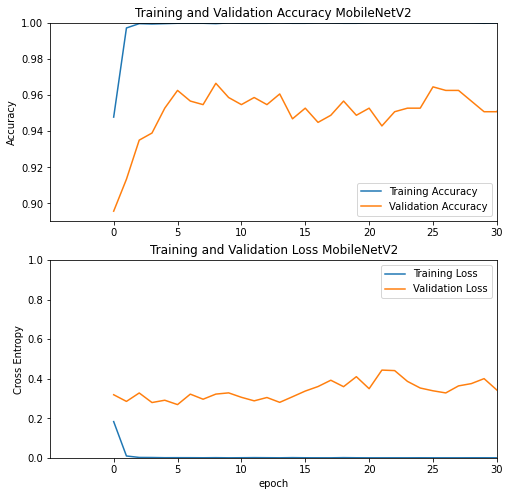

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([min(plt.xlim()),30])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy MobileNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlim([min(plt.xlim()),30])
plt.ylim([0,1.0])
plt.title('Training and Validation Loss MobileNetV2')
plt.xlabel('epoch')
plt.show()

In [ ]:
pred = model.predict(numpy_images_test,verbose=0)

In [ ]:
print(pred.shape)

(508, 6)


In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
print(numpy_labels_test)

[3 5 3 3 0 2 1 5 0 5 3 2 5 3 3 5 5 1 4 1 0 4 5 5 4 4 3 5 1 3 0 4 2 5 0 4 1
 0 0 1 4 3 1 0 3 1 1 0 1 1 4 4 4 5 4 4 5 1 4 0 4 3 3 1 1 0 0 5 3 0 3 4 0 5
 5 2 1 5 4 3 2 5 0 0 0 0 4 4 4 4 5 5 3 1 1 0 5 4 3 1 2 5 4 1 4 4 4 0 0 3 4
 4 5 5 5 4 4 5 5 0 4 5 2 5 3 4 4 5 5 0 3 0 5 3 2 5 5 5 0 4 5 3 5 4 3 5 0 5
 4 4 5 4 1 3 2 5 3 2 1 5 0 3 0 5 2 0 4 0 2 0 4 1 3 3 3 2 3 2 5 1 4 4 5 3 4
 5 3 5 1 4 5 2 2 4 2 0 4 5 5 1 2 5 3 5 1 1 2 5 5 3 1 4 5 5 0 0 5 1 2 1 5 5
 4 0 5 0 3 2 4 4 5 5 2 1 4 0 1 3 3 5 5 0 4 0 4 4 5 0 3 5 5 1 5 4 4 5 4 4 4
 4 0 5 4 4 5 1 1 2 5 3 5 2 5 5 2 1 4 4 5 5 4 5 1 0 1 0 5 5 5 5 0 0 5 3 0 0
 4 0 2 5 0 5 0 1 3 4 5 4 0 3 3 5 4 0 3 1 5 3 5 1 0 5 4 5 2 1 3 3 0 5 0 4 2
 0 0 2 5 5 1 5 5 4 5 5 1 5 5 1 5 4 0 1 2 3 4 0 0 3 1 1 0 1 4 1 3 4 5 4 2 1
 1 1 5 1 4 2 1 1 0 5 4 5 2 2 3 3 5 0 1 1 5 2 4 3 4 4 1 1 5 1 0 4 2 1 5 4 4
 1 4 5 3 2 0 5 4 3 3 4 4 0 4 0 0 4 2 2 5 4 0 5 1 4 1 1 4 0 3 3 0 1 1 5 2 4
 5 1 0 4 0 3 1 4 4 1 5 0 5 5 1 1 0 5 5 2 1 5 1 1 5 5 2 5 4 3 5 1 1 1 5 3 2
 3 3 0 5 2 4 4 4 0 1 4 1 

In [ ]:
print(pred)

[3 5 3 3 0 2 1 5 0 5 3 2 4 3 3 5 5 1 4 1 0 4 5 5 4 1 3 5 1 3 0 4 2 5 0 4 1
 0 0 1 4 3 1 0 3 1 1 0 1 1 4 4 4 5 4 4 5 1 4 0 1 3 3 1 1 0 0 5 3 0 3 4 0 5
 5 2 1 5 4 3 2 5 0 0 0 0 4 4 4 4 5 5 3 1 1 0 4 4 3 1 2 5 4 1 4 4 4 0 0 3 4
 4 5 5 5 4 4 5 5 0 4 5 2 5 3 4 4 5 5 0 3 0 5 3 2 5 5 5 0 4 5 3 5 4 3 5 0 5
 4 4 1 4 1 3 2 5 3 3 1 5 0 3 0 5 2 0 4 0 2 0 4 1 3 3 3 2 3 2 5 1 4 4 5 3 4
 5 3 5 1 4 5 2 2 4 2 0 4 5 5 1 2 5 3 5 1 1 2 5 5 3 1 4 5 5 0 0 5 1 2 1 5 5
 4 0 5 0 3 2 4 4 5 5 2 1 4 0 1 3 3 5 5 0 4 0 4 4 5 0 3 5 5 1 5 4 4 5 4 4 4
 4 0 5 4 4 5 1 1 2 3 3 5 2 5 5 2 1 4 4 5 5 4 5 1 0 1 0 3 5 4 5 0 0 5 3 0 0
 4 0 2 4 0 5 0 1 3 4 5 4 0 3 3 3 4 0 3 1 5 3 5 1 0 5 4 5 2 1 3 3 0 5 0 4 2
 0 0 2 5 5 1 5 5 4 5 5 1 5 5 1 1 4 0 1 2 3 2 0 0 3 1 1 0 1 4 1 3 4 5 4 2 1
 1 1 5 1 4 2 1 1 0 4 4 5 2 2 2 3 5 0 1 1 5 2 4 3 4 4 1 1 5 1 0 4 2 1 5 4 4
 1 4 5 3 2 0 5 4 3 3 4 4 0 4 0 0 4 2 2 5 4 0 5 1 4 1 1 2 0 3 3 0 1 1 5 2 4
 5 1 0 4 0 3 1 4 4 1 5 0 5 5 1 1 0 5 5 2 1 5 1 1 5 5 2 5 4 3 5 1 1 1 5 3 2
 3 3 0 5 3 4 4 4 0 1 4 1 

In [ ]:
unique4, counts4 = np.unique(numpy_labels_test, return_counts=True)
result4 = np.column_stack((unique4, counts4))
print(result4)

[[  0  78]
 [  1  82]
 [  2  45]
 [  3  64]
 [  4 107]
 [  5 132]]


In [ ]:
c_m = confusion_matrix(numpy_labels_test,pred,normalize='pred')
print(c_m)

[[1.         0.         0.         0.         0.         0.        ]
 [0.         0.94252874 0.         0.         0.         0.        ]
 [0.         0.         0.91489362 0.02941176 0.         0.        ]
 [0.         0.         0.0212766  0.92647059 0.         0.        ]
 [0.         0.02298851 0.06382979 0.         0.95327103 0.        ]
 [0.         0.03448276 0.         0.04411765 0.04672897 1.        ]]


In [ ]:
cm_labels4 = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']

In [ ]:
col4=['Clase %s' %(i) for i in list(cm_labels4)[0:len(np.unique(numpy_labels_test))]]

In [ ]:
conf_m4 = pd.DataFrame(c_m,index=col4,columns=col4)

<function matplotlib.pyplot.show>

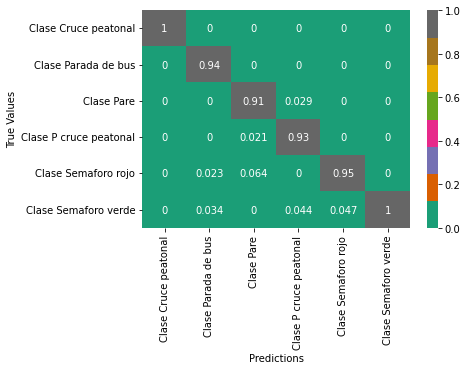

In [ ]:
draw=sns.heatmap(conf_m4,cmap='Dark2',annot=True)
plt.ylabel('True Values')
plt.xlabel('Predictions')
draw.set(xlabel='Predictions',ylabel='True Values')
plt.show

In [ ]:
print(classification_report(numpy_labels_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       0.94      1.00      0.97        82
           2       0.91      0.96      0.93        45
           3       0.93      0.98      0.95        64
           4       0.95      0.95      0.95       107
           5       1.00      0.92      0.96       132

    accuracy                           0.96       508
   macro avg       0.96      0.97      0.96       508
weighted avg       0.96      0.96      0.96       508



In [ ]:
clases = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']
img = np.random.randint(0, len(numpy_images_test))
k= pred[img]
digit = numpy_images_test[img]
l = numpy_labels_test[img]


Se realizan predicciones con los datos de prueba.

La etiqueta para esta imagen es:Semaforo rojo


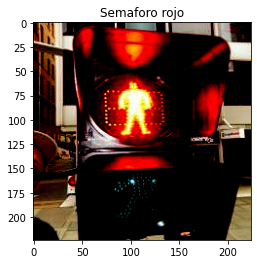

In [ ]:
plt.title(str(clases[k]))
plt.imshow(digit)
print('La etiqueta para esta imagen es:'+str(clases[l]))

La etiqueta para esta imagen es:Pare


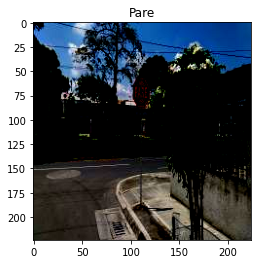

In [ ]:
plt.title(str(clases[k]))
plt.imshow(digit)
print('La etiqueta para esta imagen es:'+str(clases[l]))

La etiqueta para esta imagen es:P cruce peatonal


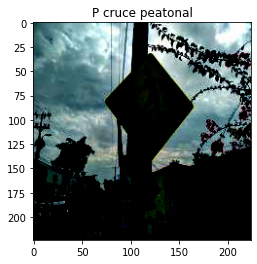

In [ ]:
plt.title(str(clases[k]))
plt.imshow(digit)
print('La etiqueta para esta imagen es:'+str(clases[l]))

La etiqueta para esta imagen es:Semaforo verde


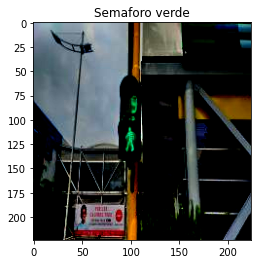

In [ ]:
plt.title(str(clases[k]))
plt.imshow(digit)
print('La etiqueta para esta imagen es:'+str(clases[l]))

La etiqueta para esta imagen es:P cruce peatonal


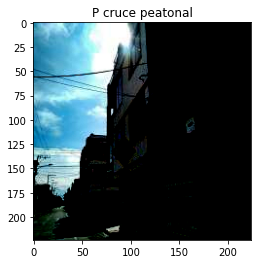

In [ ]:
plt.title(str(clases[k]))
plt.imshow(digit)
print('La etiqueta para esta imagen es:'+str(clases[l]))

La etiqueta para esta imagen es:Pare


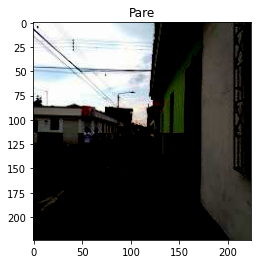

In [ ]:
plt.title(str(clases[k]))
plt.imshow(digit)
print('La etiqueta para esta imagen es:'+str(clases[l]))

La etiqueta para esta imagen es:P cruce peatonal


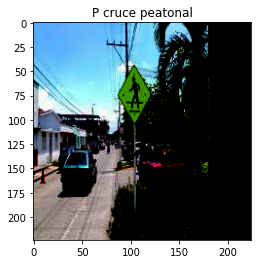

In [ ]:
plt.title(str(clases[k]))
plt.imshow(digit)
print('La etiqueta para esta imagen es:'+str(clases[l]))

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Trabajodegrado/Tesis/MobileNetV2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Trabajodegrado/Tesis/MobileNetV2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Trabajodegrado/Tesis/MobileNetV2/assets


#6. Se importa el modelo guardado para realizar mas inferencias.

In [ ]:
from tensorflow.keras.models import load_model
model_1 = load_model('/content/drive/MyDrive/Colab Notebooks/Trabajodegrado/Mobilenetv2/MobileNetV2')

In [ ]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
train_acc_list1, test_acc_list1 = [], []

train_loss1, train_acc1 = model_1.evaluate(train_batches, steps=len(train_batches))
val_loss1, val_acc1 = model_1.evaluate(validation_batches, steps=len(validation_batches))
test_loss1, test_acc1 = model_1.evaluate(test_batches, steps=len(test_batches))

train_acc_list1.append(train_acc1)
test_acc_list1.append(val_acc1)
train_acc_list1.append(test_acc1)

UnimplementedError: ignored

In [ ]:
img = image.load_img('/content/drive/MyDrive/Tesis/Imagenes_pruebas/SPRojo.jpg', target_size=(224, 224))
img = np.array(img)
img = cv2.resize(img, (224, 224))
img.reshape(-1, 224, 224, 3)
finalimg = np.expand_dims(img,axis=0)
finalimg = tf.keras.applications.mobilenet_v2.preprocess_input(finalimg)

In [ ]:
finalimg.shape

(1, 224, 224, 3)

In [ ]:
predictions = model_1.predict(finalimg)
print(predictions)

[[4.2056189e-13 7.7933943e-14 9.4656018e-17 3.0825072e-16 1.0000000e+00
  1.1657599e-16 2.1371930e-18 2.3633106e-19 5.0176166e-19 1.0423245e-17
  2.9989929e-18 3.1270837e-18]]


In [ ]:
pred = np.argmax(predictions, axis=1)
print(pred)

[4]


Text(0.5, 1.0, 'Pare')

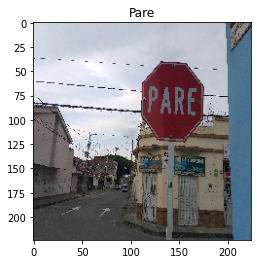

In [ ]:
clases = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']
p = pred[0]
plt.imshow(img)
plt.title(clases[p])

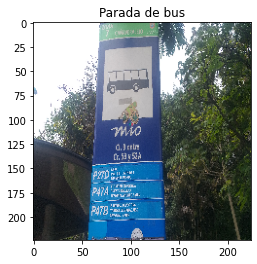

In [ ]:
clases = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']
p = pred[0]
plt.imshow(img)
plt.title(clases[p])
plt.imshow(img)

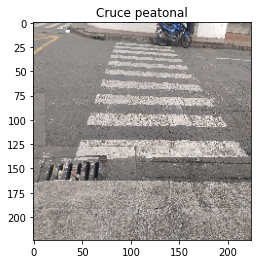

In [ ]:
clases = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']
p = pred[0]
plt.imshow(img)
plt.title(clases[p])
plt.imshow(img)

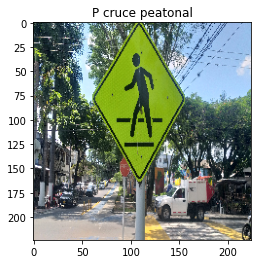

In [ ]:
clases = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']
p = pred[0]
plt.imshow(img)
plt.title(clases[p])
plt.imshow(img)

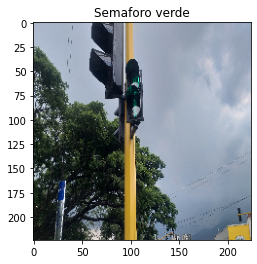

In [ ]:
clases = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']
p = pred[0]
plt.imshow(img)
plt.title(clases[p])
plt.imshow(img)

Text(0.5, 1.0, 'Semaforo rojo')

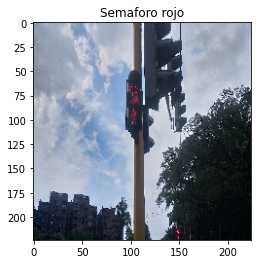

In [ ]:
clases = ['Cruce peatonal', 'Parada de bus','Pare','P cruce peatonal', 'Semaforo rojo','Semaforo verde']
p = pred[0]
plt.imshow(img)
plt.title(clases[p])

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)